## Create and test ion channel model

In [26]:
from experiments.ina_sakakibara import (sakakibara_iv,
                                        sakakibara_iv_Nao2 ,
                                        sakakibara_iv_Nao5 ,
                                        sakakibara_iv_Nao20 ,
                                        sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin_1,
                                        sakakibara_inact_kin_2,
                                        sakakibara_inact_kin_80,
                                        sakakibara_inact_kin_100,
                                        sakakibara_recov,
                                        sakakibara_recov_100,
                                        sakakibara_recov_kin)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyabc import Distribution, RV
import os, tempfile
import logging
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from pyabc import History
from ionchannelABC import plot_sim_results
import seaborn as sns
from ionchannelABC import plot_parameters_kde
from ionchannelABC.experiment import setup

In [27]:
modelfile = 'models/nygren_Na.mmt'

In [28]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1)

In [29]:
assert len(observations)==len(summary_statistics(model({})))

## Set limits and generate uniform initial priors

In [30]:

# 
#'membrane.Cm' : (0.0001,1), # keep it off 

limits = {'ina.s1' : (0,1),
          
          'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (80,120),
          'ina.q2': (-20,20),
          'ina.r1': (25,75),
          'ina.r2': (-25,25),
          'ina.q3': (0,20),
          'ina.q4': (20,80),
          'ina.q5': (-25,25),
          'ina.q6': (0,20),
          'ina.q7': (0,20),
          'ina.q8': (0,20),
          'ina.r3': (0,1),
          'ina.r4': (0,100),
          'ina.r5': (0,100),
          'ina.r6': (0,0.01)}
"""
limits = {'ina.P_Na' : (0.000001,0.05),
          'ina.q1': (0,100),
          'ina.q2': (0,100),
          'ina.r1': (0,100),
          'ina.r2': (-50,50)}
"""
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [31]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "nygren_ina_testing.db"))

In [32]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [33]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 65536 particles


In [34]:

abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(10000), #Small pop to test
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=1),
             sampler=MulticoreEvalParallelSampler(n_procs=40),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.8824874963956049, '1': 0.8824874963956049, '2': 0.8824874963956049, '3': 0.8824874963956049, '4': 0.8824874963956049, '5': 0.8824874963956049, '6': 0.8824874963956049, '7': 0.8824874963956049, '8': 0.8824874963956049, '9': 0.8824874963956049, '10': 0.8824874963956049, '11': 0.8824874963956049, '12': 0.8824874963956049, '13': 0.8824874963956049, '14': 0.8824874963956049, '15': 0.8824874963956049, '16': 0.8824874963956049, '17': 0.8824874963956049, '18': 0.3346664875905724, '19': 0.2603692152305767, '20': 0.32362044671565504, '21': 0.8824874963956049, '22': 0.8824874963956049, '23': 0.8824874963956049, '24': 0.8824874963956049, '25': 0.8824874963956049, '26': 1.042939768467533, '27': 1.042939768467533, '28': 1.042939768467533, '29': 1.042939768467533, '30': 1.042939768467533, '31': 0.3912017117154938, '32': 0.2431090065376604, '33': 0.26926837163868017, '34': 0.671767920035805, '35': 1.042939768467533, '36': 1.042939768467533, '37': 0.74924881390322

In [35]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [36]:
abc.load(db_path,60)

60

In [23]:
#abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=60, start_time=2019-08-25 00:45:45.835498, end_time=None)>


In [39]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:19 eps:0.9244853710944001
DEBUG:ABC:now submitting population 19
DEBUG:ABC:population 19 done
DEBUG:ABC:
total nr simulations up to t =19 is 7868378
DEBUG:Epsilon:new eps, t=20, eps=0.8525644831204712
INFO:ABC:t:20 eps:0.8525644831204712
DEBUG:ABC:now submitting population 20
DEBUG:ABC:population 20 done
DEBUG:ABC:
total nr simulations up to t =20 is 9821738
DEBUG:Epsilon:new eps, t=21, eps=0.8028924676460187
INFO:ABC:t:21 eps:0.8028924676460187
DEBUG:ABC:now submitting population 21
DEBUG:ABC:population 21 done
DEBUG:ABC:
total nr simulations up to t =21 is 12521461
DEBUG:Epsilon:new eps, t=22, eps=0.7507240282151071
INFO:History:Done <ABCSMC(id=60, start_time=2019-08-25 00:45:45.835498, end_time=2019-08-26 05:59:59.737174)>


# Results analysis

In [59]:
#history.all_runs()

/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/apps/anaconda3/

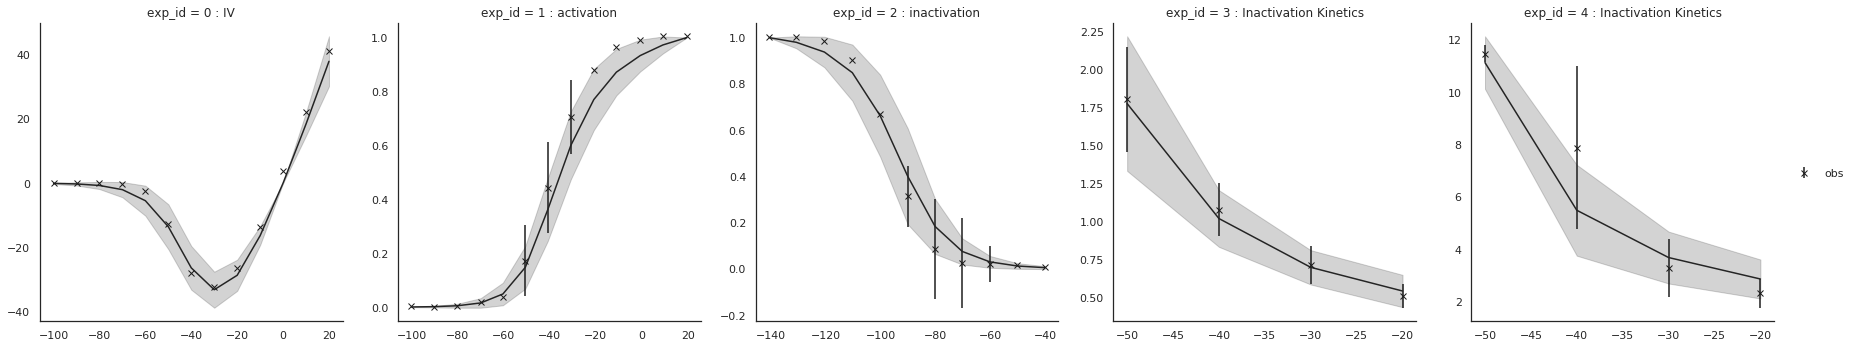

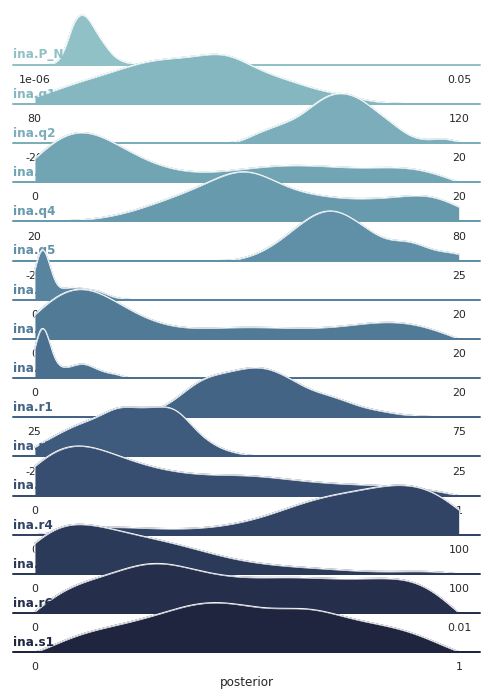

In [40]:
history = History(db_path)
history.id = 60 # (52 corresponds to the availability protocol with HP -80 mV : sakakibara_inact_kin_80)
# (54 corresponds to the availability protocol with HP -80 mV : sakakibara_inact_kin_80 with 30 iterations)
# (55 corresponds to the whole simulation without the recovery and availability experiment)
# (1 on spitfire corresponds to recovery 100)
# (56 corresponds to inactivation kinetics)

# (57 corresponds to the availability protocol with HP -100 mV : sakakibara_inact_kin_100 with mS :
# 30 pop and eps = 2.37)
# (58 corresponds to the recovery protocol with HP -100 mV : sakakibara_recov_100 with mS !!!)
# 60 corresponds to all experiments but the availability and recovery. note the final eps
df, w = history.get_distribution(m=0)
#df.describe()
grid1 = plot_sim_results(modelfile,sakakibara_iv,
                                                sakakibara_act,
                                                sakakibara_inact,
                                                sakakibara_inact_kin_1,df=df, w=w) 
grid2 = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

In [41]:
grid1.savefig('results/Ina Nygren model/ina_nygren_exp_all_saka_pop_10000.pdf')
grid2.savefig('results/Ina Nygren model/ina_nygren_post_all_saka_pop_10000.pdf')